In [15]:
import os

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib

In [16]:
gpu_number = 0 #### GPU number 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_visible_devices(gpus[gpu_number], 'GPU') 
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

2 Physical GPUs, 1 Logical GPU


In [17]:
# 폴더 안에 있는 모든 csv 파일을 읽어서 하나에 DataFrame 으로 만든다
def read_csvs_in_dir(path):
    dfs = []
    dir_files = os.listdir(path)
    file_names = list(filter(lambda x: not(x.startswith('.')), dir_files))
    for file_name in sorted(file_names):
        df = pd.read_csv(path + file_name, parse_dates=['날짜', '시간'], dayfirst=True, infer_datetime_format=True)
        dfs.append(df)
    return pd.concat(dfs)

In [18]:
# 데이터 read
df_train = read_csvs_in_dir('./data/train/')
df_false = read_csvs_in_dir('./data/test/')
df_false.tail()

,날짜,시간,대여개수,대기개수,기온,강수량
21,2022-01-02,2022-09-05 21:00:00,1224,23478,-2.9,0.0
22,2022-01-02,2022-09-05 22:00:00,963,23739,-2.9,0.0
23,2022-01-02,2022-09-05 23:00:00,638,24064,-2.9,0.0
24,2022-02-02,2022-09-05 00:00:00,429,24273,-3.9,0.0
25,2022-02-02,2022-09-05 01:00:00,425,24277,-3.9,0.0


In [19]:
df_train.describe()

,대여개수,대기개수,기온,강수량
count,8760.000000,8760.000000,8760.000000,8760.000000
mean,3976.064612,24214.636758,12.896792,0.190114
std,3279.088212,4201.261344,10.891627,1.380343
min,23.000000,11130.000000,-13.900000,0.000000
25%,1235.000000,21491.750000,4.000000,0.000000
50%,3220.000000,23970.000000,14.000000,0.000000
75%,5771.500000,26725.000000,22.000000,0.000000
max,16653.000000,34510.000000,35.000000,43.900002


In [6]:
# 전처리
def preprocess(df):
    df['날짜'] = df['날짜'].dt.dayofyear
    df['시간'] = df['시간'].dt.hour
    return df

df_true = preprocess(df_train)
df_false = preprocess(df_false)
df_false.head()

,날짜,시간,대여개수,대기개수,기온,강수량
0,2,0,257,24445,-3.9,0.0
1,2,1,285,24417,-3.9,0.0
2,2,2,194,24508,-4.9,0.0
3,2,3,100,24602,-5.9,0.0
4,2,4,45,24657,-5.9,0.0


In [7]:
input_true = df_true.values
input_false = df_false.values

timesteps = 24
n_features = input_true.shape[1]

In [8]:
# 3차원화
def temporalize(X, timesteps):
	output_X = []
	for i in range(len(X) - timesteps - 1):
		t = []
		for j in range(1, timesteps + 1):
			# Gather the past records upto the lookback period
			t.append(X[[(i + j + 1)], :])
		output_X.append(t)
	return np.squeeze(np.array(output_X))

In [9]:
x_true = temporalize(input_true, timesteps)
x_false = temporalize(input_false, timesteps)
print(x_false.shape)

(24, 6)


In [10]:
print(x_true.shape)

(8735, 24, 6)


In [11]:
x_true = temporalize(input_true, timesteps)
x_false = np.array([temporalize(input_false, timesteps)])
print(x_false.shape)

(1, 24, 6)


In [12]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

def deScale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.inverse_transform(X[i, :, :])
    return X

In [13]:
# 스케일링
scaler = StandardScaler().fit(flatten(x_true))

x_scale_true = scale(x_true, scaler)
x_scale_false = scale(x_false, scaler)

joblib.dump(scaler, "./saved_model/scaler.pkl")
print(x_scale_true.shape)

(8735, 24, 6)


In [14]:
print(x_true.shape)

(8735, 24, 6)


In [ ]:
x_train, x_valid = train_test_split(x_scale_true, test_size=0.2)
print(x_train.shape)

In [ ]:
epochs = 100000
batch = 8192
lr = 0.001

In [ ]:
lstm_ae = models.Sequential()
# Encoder
lstm_ae.add(layers.LSTM(128, input_shape=(timesteps, n_features), return_sequences=True))
lstm_ae.add(layers.LSTM(64, return_sequences=True))
lstm_ae.add(layers.LSTM(32, return_sequences=True))
lstm_ae.add(layers.LSTM(16, return_sequences=False))
lstm_ae.add(layers.RepeatVector(timesteps))
# Decoder
lstm_ae.add(layers.LSTM(16, return_sequences=True))
lstm_ae.add(layers.LSTM(32, return_sequences=True))
lstm_ae.add(layers.LSTM(64, return_sequences=True))
lstm_ae.add(layers.LSTM(128, return_sequences=True))
lstm_ae.add(layers.TimeDistributed(layers.Dense(n_features)))

lstm_ae.summary()

In [174]:
# 학습된 모델 로딩
lstm_ae = tf.keras.models.load_model('./saved_model/v2/')
lstm_ae.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 128)           69120     
                                                                 
 lstm_1 (LSTM)               (None, 24, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 24, 32)            12416     
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 repeat_vector (RepeatVector  (None, 24, 16)           0         
 )                                                               
                                                                 
 lstm_4 (LSTM)               (None, 24, 16)            2112      
                                                        

In [ ]:
# compile
lstm_ae.compile(loss='mse', optimizer=optimizers.Adam(lr))

# fit
history = lstm_ae.fit(x_train, x_train,
                     epochs=epochs, batch_size=batch,
                     validation_data=(x_valid, x_valid))

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

In [175]:
predict_false = lstm_ae.predict(x_scale_false)
print(predict_false.shape)

1/1 [==============================] - 2s 2s/step
(1, 24, 6)


In [183]:
inverse_pre_false = scaler.inverse_transform(flatten(predict_false))
print(inverse_pre_false)

[[ 3.16197006e+01  7.89266772e-01  5.06721175e+02  2.43081444e+04
  -5.75459755e+00 -2.06221405e-02]]


In [186]:
inverse_false = scaler.inverse_transform(flatten(x_scale_false))
print(inverse_false)

[[ 3.3000e+01  1.0000e+00  4.2500e+02  2.4277e+04 -3.9000e+00  0.0000e+00]]


In [190]:
mse_false = np.mean(np.power(inverse_false - inverse_pre_false, 2), axis=1)
print(mse_false)

[1275.61906008]


In [192]:
np.power(inverse_false - inverse_pre_false, 2)

array([[1.90522644e+00, 4.44084932e-02, 6.67835052e+03, 9.69974245e+02,
        3.43953206e+00, 4.25272680e-04]])

In [188]:
mse_false = np.mean(np.power(flatten(x_scale_false) - flatten(predict_false), 2), axis=1)
print(mse_false)

[0.00517252]


2022-08-08 09:03:06.653677: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 3s 3s/step


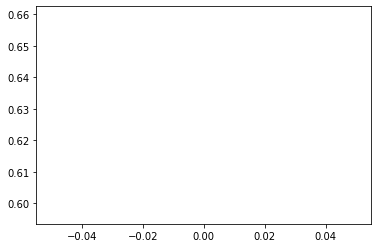

In [72]:
predict_false = lstm_ae.predict(x_scale_false)
mse_false = np.mean(np.power(flatten(x_scale_false) - flatten(predict_false), 2), axis=1)

plt.plot(np.linspace(0, len(mse_false)-1, len(mse_false)), mse_false)
#plt.ylim([0, 2])
plt.show()

In [ ]:
predict_valid = lstm_ae.predict(x_valid)
mse_valid = np.mean(np.power(flatten(x_valid) - flatten(predict_valid), 2), axis=1)

plt.plot(np.linspace(0, len(mse_valid)-1, len(mse_valid)), mse_valid)
plt.ylim([0, 2])
plt.show()

In [ ]:
# 특정 mse 기준으로 어떻게 데이터가 나뉘는지 확인
threshold_mse = 0.4

print(predict_false.shape)

In [ ]:
false_but_true = x_scale_false[mse_false <= threshold_mse].shape[0]
false_but_false = x_scale_false[mse_false > threshold_mse].shape[0]
true_but_true = x_valid[mse_valid <= threshold_mse].shape[0]
true_but_false = x_valid[mse_valid > threshold_mse].shape[0]
print(false_but_true)
print(false_but_false)
print(true_but_true)
print(true_but_false)

In [160]:
# 정밀도&재현율 계산
print("정밀도 : ", true_but_true/(true_but_true + false_but_true))
print("재현율 : ", true_but_true/(true_but_true + true_but_false))

NameError: name 'true_but_true' is not defined

In [ ]:
def createDf(array):
    return pd.DataFrame(array, columns=["날짜", "시간", "대여개수", "대기개수", "기온", "강수량"])

dfs = []
for one_input in deScale(false_but_true, scaler):
    dfs.append(createDf(one_input))
dfs[0].head()

In [ ]:
# 모델 저장
lstm_ae.save('saved_model/v3')